# Identifying Pseudo-Spatial Map

SpaceFlow is Python package for identifying spatiotemporal patterns and spatial domains from Spatial Transcriptomic (ST) Data. Based on deep graph network, SpaceFlow provides the following functions:  
1. Encodes the ST data into **low-dimensional embeddings** that reflecting both expression similarity and the spatial proximity of cells in ST data.
2. Incorporates **spatiotemporal** relationships of cells or spots in ST data through a **pseudo-Spatiotemporal Map (pSM)** derived from the embeddings.
3. Identifies **spatial domains** with spatially-coherent expression patterns.

Check out [(Ren et al., Nature Communications, 2022)](https://www.nature.com/articles/s41467-022-31739-w) for the detailed methods and applications.


![fig](https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41467-022-31739-w/MediaObjects/41467_2022_31739_Fig1_HTML.png)


In [1]:
import omicverse as ov
#print(f"omicverse version: {ov.__version__}")
import scanpy as sc
#print(f"scanpy version: {sc.__version__}")
ov.utils.ov_plot_set()


   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.5.6, Tutorials: https://omicverse.readthedocs.io/


## Preprocess data

Here we present our re-analysis of 151676 sample of the dorsolateral prefrontal cortex (DLPFC) dataset. Maynard et al. has manually annotated DLPFC layers and white matter (WM) based on the morphological features and gene markers.

This tutorial demonstrates how to identify spatial domains on 10x Visium data using STAGATE. The processed data are available at https://github.com/LieberInstitute/spatialLIBD. We downloaded the manual annotation from the spatialLIBD package and provided at https://drive.google.com/drive/folders/10lhz5VY7YfvHrtV40MwaqLmWz56U9eBP?usp=sharing.

In [ ]:
adata = sc.read_visium(path='data', count_file='151676_filtered_feature_bc_matrix.h5')
adata.var_names_make_unique()

reading data/151676_filtered_feature_bc_matrix.h5


In [ ]:
sc.pp.calculate_qc_metrics(adata, inplace=True)
adata = adata[:,adata.var['total_counts']>100]
adata=ov.pp.preprocess(adata,mode='shiftlog|pearson',n_HVGs=3000,target_sum=1e4)
adata.raw = adata
adata = adata[:, adata.var.highly_variable_features]
adata

We read the ground truth area of our spatial data

In [ ]:
# read the annotation
import pandas as pd
import os
Ann_df = pd.read_csv(os.path.join('data', '151676_truth.txt'), sep='\t', header=None, index_col=0)
Ann_df.columns = ['Ground Truth']
adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth']
sc.pl.spatial(adata, img_key="hires", color=["Ground Truth"])

## Training the SpaceFlow Model

Here, we used `ov.space.pySpaceFlow` to construct a SpaceFlow Object and train the model.

We need to store the space location info in `adata.obsm['spatial']`

In [5]:
sf_obj=ov.space.pySpaceFlow(adata)

We then train a spatially regularized deep graph network model to learn a low-dimensional embedding that reflecting both expression similarity and the spatial proximity of cells in ST data.

Parameters:
- `spatial_regularization_strength`: the strength of spatial regularization, the larger the more of the spatial coherence in the identified spatial domains and spatiotemporal patterns. (default: 0.1)
- `z_dim`: the target size of the learned embedding. (default: 50)
- `lr`: learning rate for optimizing the model. (default: 1e-3)
- `epochs`: the max number of the epochs for model training. (default: 1000)
- `max_patience`: the max number of the epoch for waiting the loss decreasing. If loss does not decrease for epochs larger than this threshold, the learning will stop, and the model with the parameters that shows the minimal loss are kept as the best model. (default: 50) 
- `min_stop`: the earliest epoch the learning can stop if no decrease in loss for epochs larger than the `max_patience`. (default: 100) 
- `random_seed`: the random seed set to the random generators of the `random`, `numpy`, `torch` packages. (default: 42)
-  `gpu`: the index of the Nvidia GPU, if no GPU, the model will be trained via CPU, which is slower than the GPU training time. (default: 0) 
-  `regularization_acceleration`: whether or not accelerate the calculation of regularization loss using edge subsetting strategy (default: True)
-  `edge_subset_sz`: the edge subset size for regularization acceleration (default: 1000000)


In [6]:
sf_obj.train(spatial_regularization_strength=0.1, 
             z_dim=50, lr=1e-3, epochs=1000, 
             max_patience=50, min_stop=100, 
             random_seed=42, gpu=0, 
             regularization_acceleration=True, edge_subset_sz=1000000)

 59%|█████▊    | 586/1000 [00:18<00:13, 31.59it/s]


array([[-8.9667696e-01, -2.8946990e-01,  4.3212128e+00, ...,
        -5.2812588e-01,  2.2033801e+00,  4.6299791e-01],
       [-7.6092196e-01, -4.1656545e-01,  4.2574883e+00, ...,
        -2.9521722e-01,  1.5641286e+00, -6.0735382e-02],
       [-4.0182848e-02, -7.6469207e-01,  4.9010983e+00, ...,
        -4.2538308e-02, -7.0747495e-01, -1.1962599e+00],
       ...,
       [-9.3121156e-02, -6.3797647e-01,  4.2939420e+00, ...,
        -1.7586024e-03, -5.9788668e-01, -1.0385087e+00],
       [-3.2560512e-01, -4.2550206e-01,  2.1340702e+00, ...,
         6.8122607e-01, -1.6583550e-01, -4.0623260e-01],
       [-5.8390421e-01, -4.7592583e-01,  3.7226861e+00, ...,
        -3.8724115e-01,  1.6883984e+00, -1.7265858e-01]], dtype=float32)

## Calculated the Pseudo-Spatial Map

Unlike the original SpaceFlow, we only need to use the `cal_PSM` function when calling SpaceFlow in omicverse to compute the pSM.

In [7]:
sf_obj.cal_pSM(n_neighbors=20,resolution=1,
                max_cell_for_subsampling=5000,psm_key='pSM_spaceflow')

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)
running Leiden clustering
    finished: found 20 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9992756  0.9970464  0.99146    0.9890401  0.9871847
     0.9807524  0.97996414 0.97583085 0.974604   0.97155374 0.96871597
     0.96345335 0.95994055 0.9569316 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigen

array([0.9664166  , 0.96921635 , 0.061254658, ..., 0.04225412 ,
       0.36782566 , 0.98252916 ], dtype=float32)

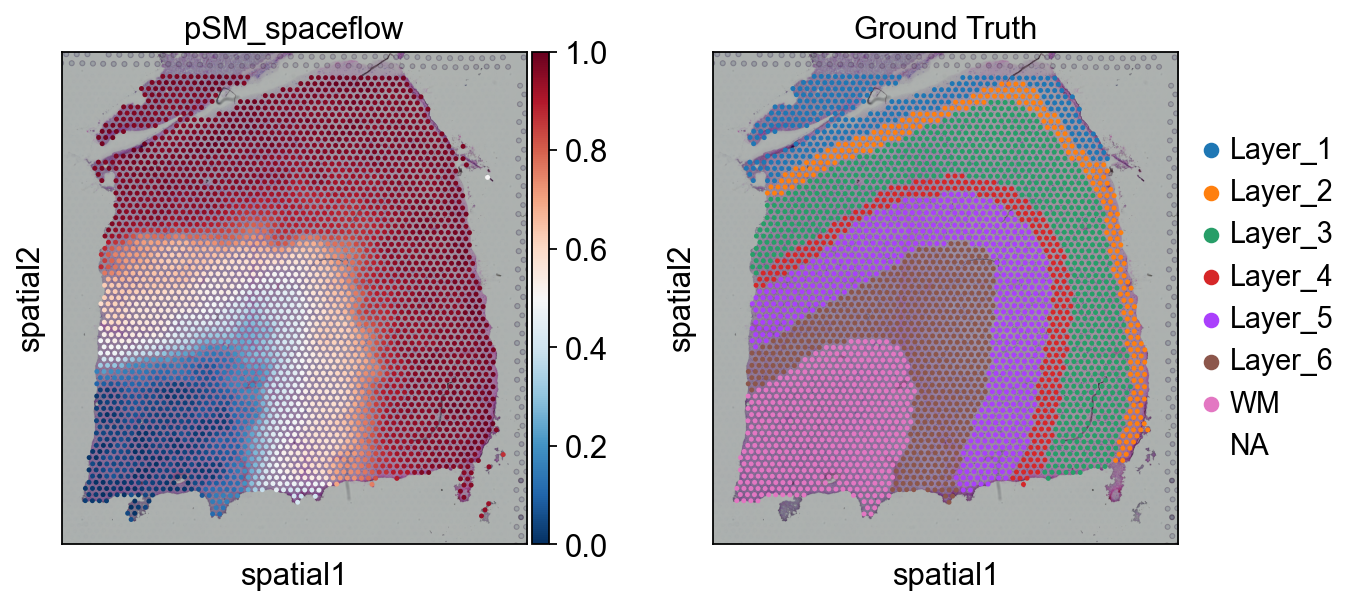

In [9]:
sc.pl.spatial(adata, color=['pSM_spaceflow','Ground Truth'],cmap='RdBu_r')

## Clustering the space

We can use `GMM`, `leiden` or `louvain` to cluster the space.

```python
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50,
               use_rep='spaceflow')
ov.utils.cluster(adata,use_rep='spaceflow',method='louvain',resolution=1)
ov.utils.cluster(adata,use_rep='spaceflow',method='leiden',resolution=1)
```

In [10]:
ov.utils.cluster(adata,use_rep='spaceflow',method='GMM',n_components=7,covariance_type='full',
                      tol=1e-9, max_iter=1000, random_state=3607)

running GaussianMixture clustering
finished: found 7 clusters and added
    'gmm_cluster', the cluster labels (adata.obs, categorical)


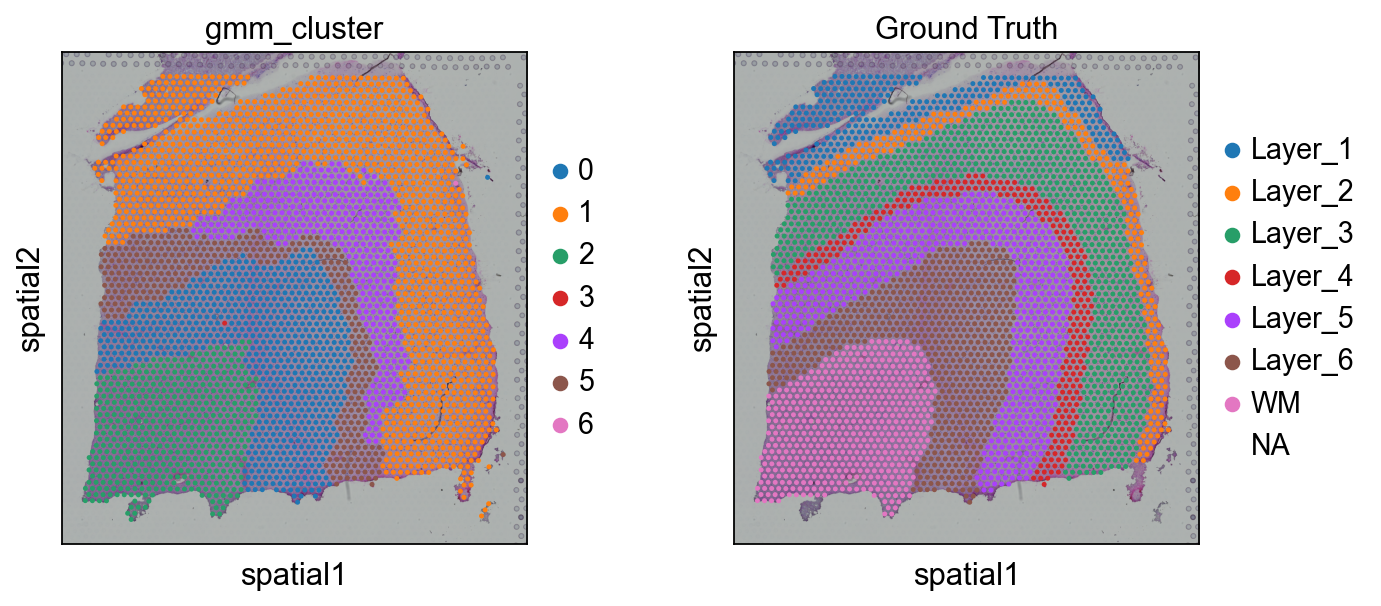

In [11]:
sc.pl.spatial(adata, color=['gmm_cluster',"Ground Truth"])